In [1]:
# Install Vectice
%pip install -q vectice -U

Note: you may need to restart the kernel to use updated packages.


### Instructions

Paste your API token below. (your token can be generated [here](https://app.vectice.com/account/api-keys) )   

Execute the cells.

Based on the Kaggle [Iris project](https://www.kaggle.com/datasets/uciml/iris).

The code shows how to integrate Vectice calls within your Data Science flow in order to do in-time/in-line documentation.    
     
This code is backed by a Vectice project "Simple Project - Hello World", located in the "Samples" worksapce of your Vectice isntance.

In [2]:
# Load libraries
import numpy as np
from datetime import date
from pandas import read_csv, DataFrame
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from vectice import connect, FileDataWrapper, models, api, Model, DatasetSourceUsage
# Set Vectice logging level
import logging
logging.getLogger("vectice").setLevel(logging.WARNING)



In [3]:
# Load dataset
url = "https://vectice-examples.s3.us-west-1.amazonaws.com/Samples+Data/iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset = read_csv(url, names=names)

In [4]:
## Goal of this sample is to simply catalog assets in Vectice

# Connect to Vectice
conn = connect(
    api_token='ynqdogKBN.6mDRJXaMkGjrobPx0LwvEynqdogKBNl69e8VYZO2dQ3WA47pgz', 
    host='https://app.vectice.com',
    workspace='Samples'
)
# Get a list of available projects
# print(conn.projects)
project = conn.project("Simple Project - Hello World")

2023/01/25 15:39:11 WARNING vectice.connection: No Iteration exists with activity. When an Iteration is created, last used assets will be displayed.


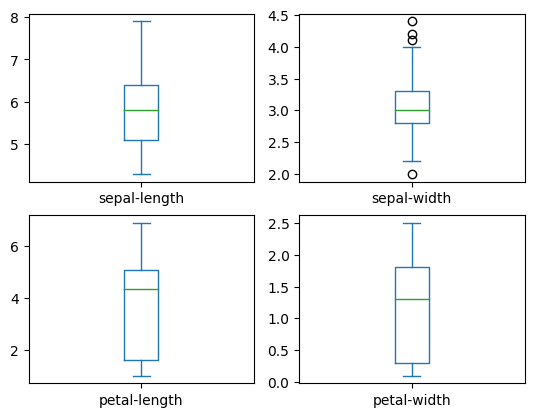

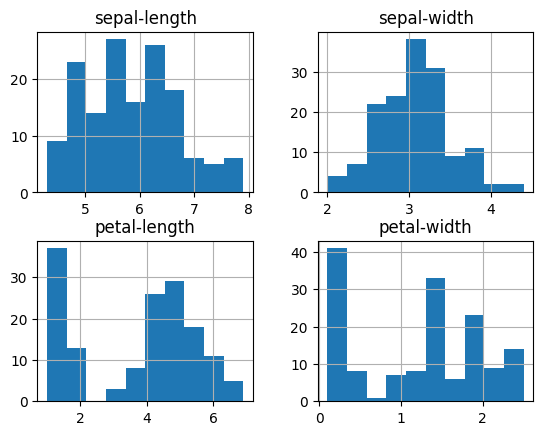

In [5]:
# Plot the dataset
dataset.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
boxplot = pyplot.savefig("boxplot.jpg")
pyplot.show()

# histograms
dataset.hist()
histogram = pyplot.savefig("histogram.jpg")
pyplot.show()

In [6]:
# Capture the origin_dataset in Vectice for documentation
dataset.to_csv("iris.csv")
project.origin_dataset = FileDataWrapper(name="Original Iris Dataset", path="iris.csv")

# Clean the dataset and materialise it
# Do more data prep/cleaning here
dataset = dataset.fillna(0)
dataset.to_csv("iris_clean.csv")


# Split-out validation dataset
array = dataset.values
Xarray = array[:,0:4]
X = DataFrame(array[:,0:4])
Yarray = array[:,4]
y = DataFrame(array[:,4])

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

# Build Vectice dataset objects
X_train.to_csv("traindataset.csv")
X_validation.to_csv("testdataset.csv")
Y_validation.to_csv("validatedataset.csv")

clean_ds = FileDataWrapper(name="Clean Iris Dataset", path="iris_clean.csv")

train_ds = FileDataWrapper(name="Modeling Dataset", path="traindataset.csv", usage=DatasetSourceUsage.TRAINING)
test_ds = FileDataWrapper(name="Modeling Dataset", path="testdataset.csv", usage=DatasetSourceUsage.TESTING)
validate_ds = FileDataWrapper(name="Modeling Dataset", path="validatedataset.csv", usage=DatasetSourceUsage.VALIDATION)

# Set the project clean model - this model will be used to derive training, testing, and validation datasets
prjPhase = project.phase("Modeling Techniques")
prjPhase.clean_dataset = clean_ds

2023/01/25 15:39:16 WARNING vectice.models.project: No phase has been selected in the session.
2023/01/25 15:39:18 WARNING vectice.models.phase: The code commit exists already.
2023/01/25 15:39:19 WARNING vectice.models.phase: There is no active iteration to link asset to.


In [7]:
# Spot Check Algorithms
models = []
models.append(('Logistic Regression', 'LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('Linear Discriminant Analysis', 'LDA', LinearDiscriminantAnalysis()))
models.append(('KNeighbors Classifier', 'KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier','CART',  DecisionTreeClassifier()))
models.append(('Gaussian NB', 'NB', GaussianNB()))
models.append(('Support Vector Classifier','SVM', SVC(gamma='auto')))

# evaluate each model in turn
results = []
names = []
labels = []
means = []
# Create a single iteration - One model - each version of it represents a model defined above
iterStep = prjPhase.iteration().step("Build Model")
 # Document the associated dataset used for this iteration
iterStep.iteration.modeling_dataset = [train_ds, test_ds, validate_ds]
for name, label, model in models:
 kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
 scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro'}
 cv_results = cross_validate(model, X_train, np.ravel(Y_train), cv=kfold, scoring=scoring)
 results.append(cv_results['test_acc'])
 means.append(np.mean(cv_results['test_acc']))
 labels.append(label)
 names.append(name)
 metrics = {"Accuracy Mean": cv_results['test_acc'].mean(), 
            "Accuracy Std.": cv_results['test_acc'].std(), 
            "Score Time Mean": cv_results['score_time'].mean(),
            "Score Time Std.": cv_results['score_time'].std()}
 # Document model in Vectice - 1 line
 iterStep.iteration.model = Model(name= 'Iris Classification Models_' + str(date.today()) , library= name, technique=name, metrics=metrics, attachments=['boxplot.jpg','histogram.jpg'], capture_code= True)
# Commit and close the iteration
winner = DataFrame({'label':names, 'value': means}).max()
iterStep.close(message="Iteration done\nThe model with the best accuracy mean is " + winner["label"] + ", with a mean accuracy value of: " + str(winner["value"]))


2023/01/25 15:39:21 WARNING vectice.models.iteration: The code commit exists already.
2023/01/25 15:39:25 WARNING vectice.models.iteration: The code commit exists already.
2023/01/25 15:39:32 WARNING vectice.models.iteration: The code commit exists already.
2023/01/25 15:39:39 WARNING vectice.models.iteration: The code commit exists already.
2023/01/25 15:39:46 WARNING vectice.models.iteration: The code commit exists already.
2023/01/25 15:39:53 WARNING vectice.models.iteration: The code commit exists already.
2023/01/25 15:40:00 WARNING vectice.models.iteration: The code commit exists already.


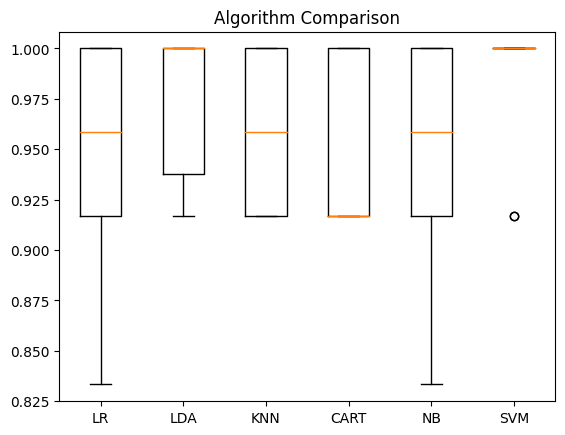

In [8]:
# Compare Algorithms
pyplot.boxplot(results, labels=labels)
pyplot.title('Algorithm Comparison')
pyplot.savefig("algComp.jpg")
pyplot.show()

In [9]:
# Based on the plot above it looks like SVM is getting us the most accurate results
# This has already been documented in Vectice in the previous cell whenclosing the iteration

# Let's get an understanding of the accuracy of our model using our validation dataset

# Make predictions on validation dataset
model = SVC(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

# Get the next phase in the Vectice project to document my iteration of the SVM model
phaseIter = project.phase("Model Iterations").iteration()
iterStep = phaseIter.step("Fine Tune Model")
metrics = {"Mean Accuracy": winner["value"]}
 # Document the associated dataset used for this iteration
iterStep.iteration.modeling_dataset = [train_ds, test_ds, validate_ds]
iterStep.iteration.model = Model(name= 'Iris Classification Models_' + winner["label"] , library= winner["label"], technique=winner["label"], metrics=metrics, attachments=['boxplot.jpg','histogram.jpg'])
iterStep.close(message="Classification report:\n" + classification_report(Y_validation, predictions))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9666666666666667
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.86      1.00      0.92         6

       accuracy                           0.97        30
      macro avg       0.95      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



2023/01/25 15:40:08 WARNING vectice.models.iteration: The code commit exists already.
2023/01/25 15:40:12 WARNING vectice.models.iteration: The code commit exists already.


In [15]:
# Fine tune the SVM model and check for improvement
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

param_grid = {'C':[0.1,1,10,100], 'gamma':[1,0.1,0.01,0.001]}
scoring = {
 'accuracy_score': make_scorer(accuracy_score)
}
grid = GridSearchCV(SVC(), param_grid, refit = 'accuracy_score', verbose=0)
grid.fit(X_train, np.ravel(Y_train))

pred_grid = grid.predict(X_validation)
tunedAccScore  = accuracy_score(Y_validation, pred_grid)
# Evaluate predictions
print(accuracy_score(Y_validation, pred_grid))
print(confusion_matrix(Y_validation, pred_grid))
print(classification_report(Y_validation, pred_grid))
# Document findings in Vectice
message = ""
mod = "base"
if winner["value"] > tunedAccScore:
    message = "The tuned model is less accurate than our base model."
elif winner == tunedAccScore:
    message = "The tuned model performs the same as the base model."
else:
    message = "The tuned model shows a relevant improvement over the base model."
    mod = "tuned"
message += "\nModel name: " + winner["label"] + "\nParameter grid:" + str(param_grid) + "\nBase model accuracy score:" + str(winner["value"]) + "\nTuned model accuracy score: " + str(tunedAccScore)
message += "\n\nRecommend deploying the {e} model." .format(e=mod)
phaseIter = project.phase("Model Iterations").iteration()
iterStep = phaseIter.step("Fine Tune Model")
metrics = {"Mean Accuracy": tunedAccScore}
iterStep.iteration.modeling_dataset = [test_ds,train_ds, validate_ds]
iterStep.iteration.model = Model(name= 'Iris Classification Models_' + winner["label"] , library= winner["label"], technique=winner["label"], metrics=metrics, attachments=['boxplot.jpg','histogram.jpg'])
iterStep.close(message=message)


0.9666666666666667
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.86      1.00      0.92         6

       accuracy                           0.97        30
      macro avg       0.95      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



2023/01/25 15:49:05 WARNING vectice.models.iteration: The code commit exists already.
2023/01/25 15:49:09 WARNING vectice.models.iteration: The code commit exists already.


<bound method Step.next_step of Step(name='Fine Tune Model', id=13181, description='', completed=True)>

### End of sample